In [2]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
import pandas as pd

### Simple models
In this file, we tried to train our model very simply, without advanced techniques to encode the tweets.

In [3]:
from cooc import *
#rom glove_template import *
from pickle_vocab import *
from preprocessing import pre_process
from helpers import *

In [4]:
# creating training data
full_train=load_data()

In [5]:
full_train.sample(5)

,data,target
190064,"kohinoor rice & curry , pindi chana masala wit...",:(
56514,<url> i love this song hear it right now\n,:)
53004,my younger sister wakes up every morning at 6 ...,:)
102643,mainstreaming midwives : the politics of chang...,:(
187965,12x27 custom picture frame / poster frame . 88...,:(


In [6]:
from sklearn.model_selection import train_test_split

train , test=train_test_split(full_train)

### Bayes Classifier

In [7]:
# Extracting features from text files
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train.data)
X_train_counts.shape

(150000, 85161)

In [8]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(150000, 85161)

In [9]:
# Training Naive Bayes (NB) classifier on training data.
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, train.target)

In [10]:
from sklearn.pipeline import Pipeline

text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])

text_clf = text_clf.fit(train.data, train.target)

In [13]:
predicted = text_clf.predict(test.data)
print('Accuracy of Naive Bayes CLassifier: ', np.mean(predicted == test.target))

Accuracy of Naive Bayes CLassifier:  0.76564


### SVM

In [14]:
from sklearn.linear_model import SGDClassifier

text_clf_svm = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-5, max_iter=100, random_state=42))])

text_clf_svm = text_clf_svm.fit(train.data, train.target)
predicted_svm = text_clf_svm.predict(test.data)
print('Accuracy of Support Vector Machine model: ',np.mean(predicted_svm == test.target))

Accuracy of Support Vector Machine model:  0.81362


For both models, we got quite good accuracy, especially for SVM. Theses models are interesting as they are very simple and efficient.

### Logistic regression TF-IDF and Count Vectorizer


In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time
from sklearn.metrics import accuracy_score

x_train, y_train, x_test, y_test= train.data, train.target, test.data, test.target

def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    print ("train and test time: {0:.2f}s".format(train_test_time))
    print ("-"*80)
    return accuracy, train_test_time

cvec = CountVectorizer()
lr = LogisticRegression(max_iter=1000)
n_features = np.arange(10000,100001,10000)
#n=80000

def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print(classifier)
    print ("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([('vectorizer', vectorizer),('classifier', classifier)])
        print ("Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_test, y_test)
        result.append((n,nfeature_accuracy,tt_time))
    
    return result

from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer()

feature_result_ugt = nfeature_accuracy_checker(vectorizer=tvec)
feature_result_bgt = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 2))
feature_result_tgt = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 3))

LogisticRegression(max_iter=1000)


Validation result for 10000 features
accuracy score: 80.66%
train and test time: 6.80s
--------------------------------------------------------------------------------
Validation result for 20000 features
accuracy score: 80.87%
train and test time: 6.59s
--------------------------------------------------------------------------------
Validation result for 30000 features
accuracy score: 80.89%
train and test time: 7.89s
--------------------------------------------------------------------------------
Validation result for 40000 features
accuracy score: 80.86%
train and test time: 7.70s
--------------------------------------------------------------------------------
Validation result for 50000 features
accuracy score: 80.88%
train and test time: 6.18s
--------------------------------------------------------------------------------
Validation result for 60000 features
accuracy score: 80.85%
train and test time: 6.78s
-------------------------------------

'""\nnfeatures_plot_tgt = pd.DataFrame(feature_result_tgt,columns=[\'nfeatures\',\'validation_accuracy\',\'train_test_time\'])\nnfeatures_plot_bgt = pd.DataFrame(feature_result_bgt,columns=[\'nfeatures\',\'validation_accuracy\',\'train_test_time\'])\nnfeatures_plot_ugt = pd.DataFrame(feature_result_ugt,columns=[\'nfeatures\',\'validation_accuracy\',\'train_test_time\'])\nplt.figure(figsize=(8,6))\nplt.plot(nfeatures_plot_tgt.nfeatures, nfeatures_plot_tgt.validation_accuracy,label=\'trigram tfidf vectorizer\',color=\'royalblue\')\nplt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy,label=\'trigram count vectorizer\',linestyle=\':\', color=\'royalblue\')\nplt.plot(nfeatures_plot_bgt.nfeatures, nfeatures_plot_bgt.validation_accuracy,label=\'bigram tfidf vectorizer\',color=\'orangered\')\nplt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label=\'bigram count vectorizer\',linestyle=\':\',color=\'orangered\')\nplt.plot(nfeatures_plot_ugt.nfea

In [15]:
feature_result_ug = nfeature_accuracy_checker(vectorizer=cvec)
feature_result_bg = nfeature_accuracy_checker(vectorizer=cvec,ngram_range=(1, 2))
feature_result_tg  = nfeature_accuracy_checker(vectorizer=cvec,ngram_range=(1, 3))

LogisticRegression(max_iter=1000)


Validation result for 10000 features
accuracy score: 80.63%
train and test time: 10.79s
--------------------------------------------------------------------------------
Validation result for 20000 features
accuracy score: 80.83%
train and test time: 12.20s
--------------------------------------------------------------------------------
Validation result for 30000 features
accuracy score: 80.93%
train and test time: 14.38s
--------------------------------------------------------------------------------
Validation result for 40000 features
accuracy score: 80.96%
train and test time: 14.26s
--------------------------------------------------------------------------------
Validation result for 50000 features
accuracy score: 80.97%
train and test time: 15.84s
--------------------------------------------------------------------------------
Validation result for 60000 features
accuracy score: 81.00%
train and test time: 16.29s
-------------------------------

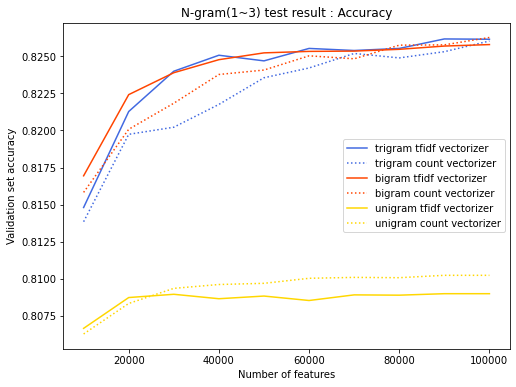

In [16]:
nfeatures_plot_tgt = pd.DataFrame(feature_result_tgt,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bgt = pd.DataFrame(feature_result_bgt,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ugt = pd.DataFrame(feature_result_ugt,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_tg = pd.DataFrame(feature_result_tg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bg = pd.DataFrame(feature_result_bg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','train_test_time'])
plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tgt.nfeatures, nfeatures_plot_tgt.validation_accuracy,label='trigram tfidf vectorizer',color='royalblue')
plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy,label='trigram count vectorizer',linestyle=':', color='royalblue')
plt.plot(nfeatures_plot_bgt.nfeatures, nfeatures_plot_bgt.validation_accuracy,label='bigram tfidf vectorizer',color='orangered')
plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label='bigram count vectorizer',linestyle=':',color='orangered')
plt.plot(nfeatures_plot_ugt.nfeatures, nfeatures_plot_ugt.validation_accuracy, label='unigram tfidf vectorizer',color='gold')
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='unigram count vectorizer',linestyle=':',color='gold')
plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()


### Other models with TF-IDF

In [21]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier

names = ["Logistic Regression", "Linear SVC", "LinearSVC with L1-based feature selection","Multinomial NB", 
         "Bernoulli NB", "Ridge Classifier", "AdaBoost", "Perceptron","Passive-Aggresive", "Nearest Centroid"]
classifiers = [
    LogisticRegression(),
    LinearSVC(),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
  ('classification', LinearSVC(penalty="l2"))]),
    MultinomialNB(),
    BernoulliNB(),
    RidgeClassifier(),
    AdaBoostClassifier(),
    Perceptron(),
    PassiveAggressiveClassifier(),
    NearestCentroid(),
   ]

zipped_clf = zip(names,classifiers)
n=90000

tvec = TfidfVectorizer()
def classifier_comparator(vectorizer=tvec, n_features=10000, stop_words=None, ngram_range=(1, 1), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', c)
        ])
        print ("Validation result for {}".format(n))
        print (c)
        clf_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_test, y_test)
        result.append((n_features,clf_accuracy,tt_time))
    return result

trigram_result = classifier_comparator(n_features=100000,ngram_range=(1,3))

Validation result for Logistic Regression
LogisticRegression()
accuracy score: 82.62%
train and test time: 17.29s
--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC()
accuracy score: 82.34%
train and test time: 18.36s
--------------------------------------------------------------------------------
Validation result for LinearSVC with L1-based feature selection
Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(dual=False,
                                                     penalty='l1'))),
                ('classification', LinearSVC())])
accuracy score: 82.43%
train and test time: 23.96s
--------------------------------------------------------------------------------
Validation result for Multinomial NB
MultinomialNB()
accuracy score: 80.26%
train and test time: 14.88s
--------------------------------------------------------------------------------
Validation result for Be